<span style=float:right><img src='./img/header.jpg' alt='DestinE' align='center' width='100%'></img>

# How to discover and access data from DestinE Platform

## Pre-requisites 

### Create a virtual environment with required packages

Open a terminal window and run the following commands in sequence.

1. Create a virtual environment: `python -m venv /home/jovyan/my_env`
2. Activate it: `source /home/jovyan/my_env/bin/activate`
3. Install required dependencies for this example Notebook:
```
pip install lxml pydantic-settings pyjwt[crypto] requests colorama
pip install xarray[complete]
pip install rioxarray
pip install cartopy
pip install ipykernel

```
4. Add kernel to Notebook `ipython kernel install --user --name=my_env`
5. Select the kernel `my_env` from the top-right menu of this notebook
6. You need to have an account on the [Destination Earth Platform](https://auth.destine.eu/realms/desp/account) 

### Importing required libraries

In [1]:
import requests
import os
import json
from random import randrange
from urllib.parse import urlparse
import colorama
from colorama import Fore,Style
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm as cm
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray
import warnings
warnings.filterwarnings("ignore")

#### **Step 1:** Authentication

The HDA endpoint and the corresponding token to access the catalogue are defined

In [2]:
hdaednpoint = 'https://broker.eden.destine.eu'

In [3]:
%%capture cap
%run ./auth.py

Type your username :  ········
Type your password :  ········


In [4]:
output_1 = cap.stdout.split('}\n')
token = output_1[-1][0:-1]

#### **Step 2:** Browsing the catalogue

The following code extract the full list of datasets that are available in the catalogue. The list is returned as a json object.

In [5]:

#--------------extracting the list of datasets----------------
getDatasets = requests.get(hdaednpoint + '/api/v1/datasets').json()
datasetList = getDatasets['features']

#--------------visualization of the list----------------
print(Fore.RED + '\033[1m' + 'List of available datasets:')
print('----------------------------------------------------------------------')
print ('\033[0m')

for i in getDatasets['features']:
         print(Style.BRIGHT + Fore.RED + i['metadata']['title'] + Fore.BLACK + "\033[1m" + " --> datasetId "+ "\033[0m" + "= " + i['dataset_id'])


List of available datasets:
----------------------------------------------------------------------

EO:ECMWF:DAT:REANALYSIS_ERA5_LAND:COG --> datasetId = EO:ECMWF:DAT:REANALYSIS_ERA5_LAND:COG
EO:ECMWF:DAT:REANALYSIS_ERA5_SINGLE_LEVELS:COG --> datasetId = EO:ECMWF:DAT:REANALYSIS_ERA5_SINGLE_LEVELS:COG
ERA5 hourly data on single levels from 1940 to present --> datasetId = EO:ECMWF:DAT:REANALYSIS_ERA5_SINGLE_LEVELS
ERA5-Land hourly data from 1950 to present --> datasetId = EO:ECMWF:DAT:REANALYSIS_ERA5_LAND
ERA5 monthly averaged data on single levels from 1940 to present --> datasetId = EO:ECMWF:DAT:REANALYSIS_ERA5_SINGLE_LEVELS_MONTHLY_MEANS
ERA5-Land monthly averaged data from 1950 to present --> datasetId = EO:ECMWF:DAT:REANALYSIS_ERA5_LAND_MONTHLY_MEANS


#### **Step 3.** Querables extraction
For a given dataset, specified by its **datasetId**, the following code shows the list of available querables to be used for the data discovery operation. 

In [6]:

#--------------extracting the list of quearables----------------
datasetID = 'EO:ECMWF:DAT:REANALYSIS_ERA5_LAND:COG'

getParam = requests.get(os.path.join(hdaednpoint, "api/v1/dataaccess/queryable/",datasetID), headers={"Authorization": "Bearer %s " % token}).json()


#--------------printing the list of querables----------------
print(Fore.BLUE + '\033[1m' + 'List of available querables:')
print('----------------------------------------------------------------------')
print ('\033[0m')
    
for filter,v in getParam['properties'].items():
    print(Style.BRIGHT + Fore.RED + str(filter),Fore.BLACK + str(v))
    print('')

List of available querables:
----------------------------------------------------------------------

dataset_id {'title': 'dataset_id', 'type': 'string', 'oneOf': [{'const': 'EO:ECMWF:DAT:REANALYSIS_ERA5_LAND:COG', 'title': 'EO:ECMWF:DAT:REANALYSIS_ERA5_LAND:COG', 'group': None}]}

itemsPerPage {'title': 'itemsPerPage', 'type': 'string', 'pattern': '^[0-9]*$'}

startIndex {'title': 'startIndex', 'type': 'string', 'pattern': '^[0-9]*$'}

subDatasetId {'title': 'title', 'type': 'string', 'oneOf': [{'const': '10m_u_component_of_wind', 'title': '10m_u_component_of_wind'}, {'const': '10m_v_component_of_wind', 'title': '10m_v_component_of_wind'}, {'const': '2m_dewpoint_temperature', 'title': '2m_dewpoint_temperature'}, {'const': '2m_temperature', 'title': '2m_temperature'}, {'const': 'surface_solar_radiation_downwards', 'title': 'surface_solar_radiation_downwards'}, {'const': 'total_precipitation', 'title': 'total_precipitation'}]}

endDate {'title': 'endDate', 'type': 'string', 'format': 'd

#### **Step 4**. Basic search operation
A simple product search is implemented, providing the datasetID of the desired dataset and a bounding box as the only constraint for the search. The output will be a Json object containing the metadata of the first 10 products available in the catalogue. For each product, a selection of its metadata will be printed in the list

In [7]:

#--------------defining the parameters for the search operation----------------
maxRecords = '10'
data = {
    "dataset_id": "EO:ECMWF:DAT:REANALYSIS_ERA5_LAND:COG",
    "itemsPerPage": maxRecords,
    "startIndex": "0",
    "bbox": [-10,10,10,-10],
    # "startDate": "2024-04-10T20:00:00Z",
    # "endDate": "2024-04-10T20:00:00Z",
    "subDatasetId":"2m_temperature"
}

##--------------running the search operation----------------
getProducts = requests.post(os.path.join(hdaednpoint, "api/v1/dataaccess/search"), headers={"Authorization": "Bearer %s " % token}, data=json.dumps(data))

results = getProducts.json()


#--------------printing the results of the search----------------
total = results['properties']['totalResults']

if total>int(maxRecords):
    print(Fore.BLACK + 'List of the ' + str(maxRecords) + ' most recent products')
else:
    print(Fore.BLACK + 'List of the ' + str(total)+ ' most recent products')
count = 1
for i in results["features"]:
    print("\033[1;30;1m" + '-----------------------------------------------')
    print("\033[1;30;1m" + "#" + str(count))
    print ('\033[0m')
    print(Style.BRIGHT + Fore.RED + 'product: ' + Fore.GREEN + i['id'])
    print(Style.BRIGHT + Fore.RED + 'start date: ' + Fore.GREEN + i['properties']['startdate'])
    print(Style.BRIGHT + Fore.RED + 'end date: ' + Fore.GREEN +i['properties']['enddate'])
    print(Style.BRIGHT + Fore.RED + 'location: ' + Fore.BLUE + i['properties']['location'])
    count = count+1

List of the 10 most recent products
-----------------------------------------------
#1

product: EO_ECMWF_DAT_REANALYSIS_ERA5_LAND_COG_20240412230000_2m_temperature
start date: 2024-04-12T23:00:00Z
end date: 2024-04-12T23:00:00Z
location: https://broker.datawkfl.e2e.desp.space/api/v1/catalog/download/L0VPOkVDTVdGOkRBVDpSRUFOQUxZU0lTX0VSQTVfTEFORDpDT0cvMjAyNC8wNC8xMi9FT19FQ01XRl9EQVRfUkVBTkFMWVNJU19FUkE1X0xBTkRfQ09HXzJtX3RlbXBlcmF0dXJlXzIwMjQwNDEyMjMwMDAwLnRpZg==
-----------------------------------------------
#2

product: EO_ECMWF_DAT_REANALYSIS_ERA5_LAND_COG_20240412220000_2m_temperature
start date: 2024-04-12T22:00:00Z
end date: 2024-04-12T22:00:00Z
location: https://broker.datawkfl.e2e.desp.space/api/v1/catalog/download/L0VPOkVDTVdGOkRBVDpSRUFOQUxZU0lTX0VSQTVfTEFORDpDT0cvMjAyNC8wNC8xMi9FT19FQ01XRl9EQVRfUkVBTkFMWVNJU19FUkE1X0xBTkRfQ09HXzJtX3RlbXBlcmF0dXJlXzIwMjQwNDEyMjIwMDAwLnRpZg==
-----------------------------------------------
#3

product: EO_ECMWF_DAT_REANALYSIS_ERA5_LAND_COG_202

#### **Step 5.**  Product Download

From the short list of 10 products retrieved in the previous step, one product is directly downloaded in cache. 

In [8]:
#--------------setting the parameters for the download request----------------
data = {
    "dataset_id": "EO:ECMWF:DAT:REANALYSIS_ERA5_LAND:COG",
    "product_id": "EO_ECMWF_DAT_REANALYSIS_ERA5_LAND_COG_20240410230000_2m_temperature",
    "location": "https://broker.eden.destine.eu/api/v1/catalog/download/L0VPOkVDTVdGOkRBVDpSRUFOQUxZU0lTX0VSQTVfTEFORDpDT0cvMjAyNC8wNC8xMC9FT19FQ01XRl9EQVRfUkVBTkFMWVNJU19FUkE1X0xBTkRfQ09HXzJtX3RlbXBlcmF0dXJlXzIwMjQwNDEwMjMwMDAwLnRpZg=="
}

#--------------running the download request----------------
pdownload = requests.post(
    os.path.join(hdaednpoint, "api/v1/dataaccess/download"),
    headers={"Authorization": "Bearer %s " % token},
    data=json.dumps(data)
)
print(pdownload.json())

{'Location': 'http://broker.eden.destine.eu/api/v1/dataaccess/download/66228654df6d77edd9fdd8a3', 'download_id': '66228654df6d77edd9fdd8a3'}


#### **Step 6.** Download verification

The following lines of code verify that the product has been definitely downloaded and is available in cache. Copy-paste the `download_id` field.

In [9]:
while True:
    hdownload = requests.head(os.path.join(hdaednpoint, "api/v1/dataaccess/download/", "66213aa63afe2cfd6844d391"),
                              headers={"Authorization": "Bearer %s " % token})
    if hdownload.status_code == 200:
        break
    else:
        print("wait I'm caching")
print('Done!')

Done!


In [10]:
#--------------downloading the product and saving it in the jupyter environment----------------
hdownload = requests.get(os.path.join(hdaednpoint, "api/v1/dataaccess/download/", "66213aa63afe2cfd6844d391"),
                              headers={"Authorization": "Bearer %s " % token})

with open("response.tif", "wb") as f:
    f.write(hdownload.content)

#### **Step 7.** Data visualization

The downloaded product will be read with the **xarray** library and then plotted on a map, using  the available python packages
for data visualization

In [13]:
dataset = xarray.open_dataset('response.tif')
dataset

<xarray.Dataset> Size: 26MB
Dimensions:      (band: 1, x: 3600, y: 1801)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 29kB -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * y            (y) float64 14kB 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
    spatial_ref  int64 8B ...
Data variables:
    band_data    (band, y, x) float32 26MB ...

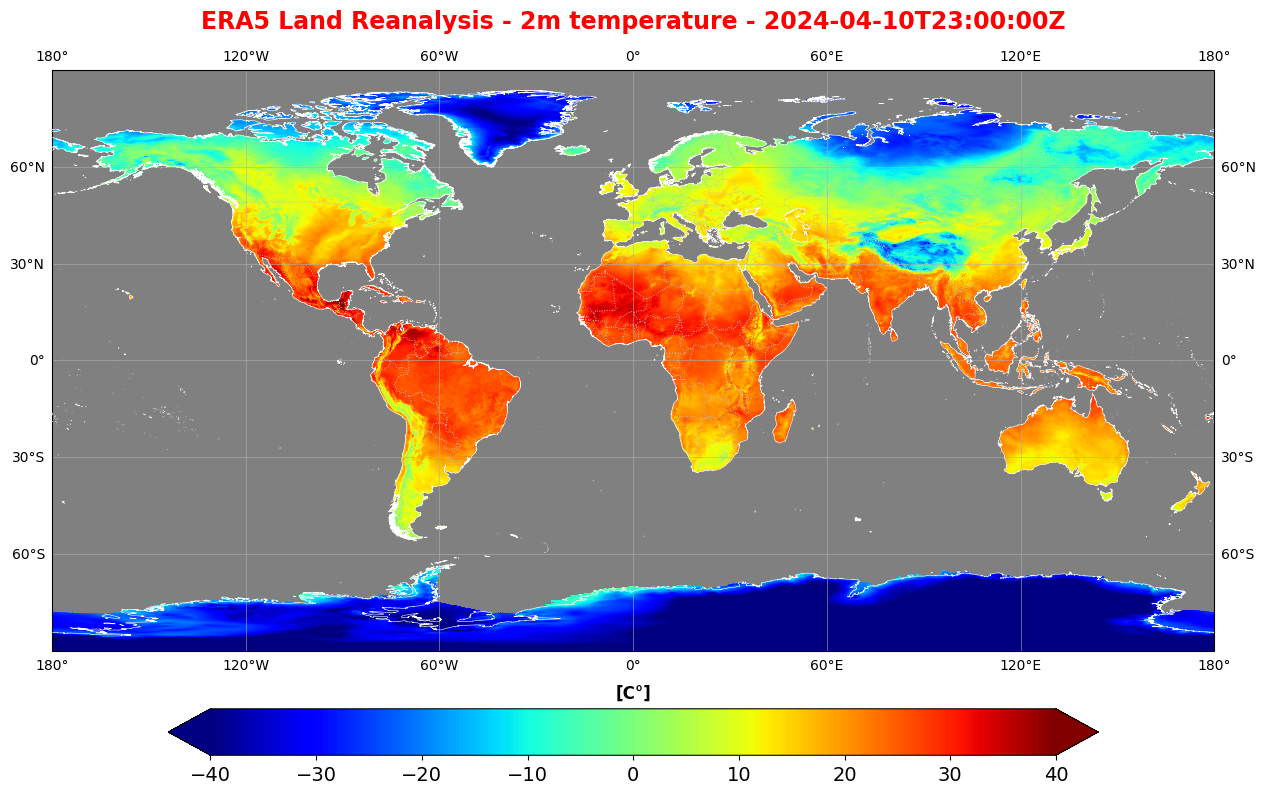

In [14]:
#--------------setting map and gridlines----------------

fig=plt.figure(figsize=(15,15))
cmap = cm.jet
cmap.set_bad('None')
ax = plt.axes(projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True, linewidth=0.4)
ax.coastlines(resolution='10m',linewidth=0.4,color = 'white',zorder=3)
ax.add_feature(cfeature.BORDERS, linestyle=':',linewidth=0.7,edgecolor = 'silver')
ax.add_feature(cfeature.OCEAN,facecolor = 'grey')
plt.title('ERA5 Land Reanalysis - 2m temperature - 2024-04-10T23:00:00Z',fontsize=17, fontweight = 'bold', pad = 15, color = 'red')
gl.xlabels_top = False
gl.ylabels_right = False

#--------------setting the colorbar----------------
img = ax.pcolormesh(dataset.x, dataset.y, dataset.band_data.values[0,:,:]-273.15, cmap = cmap,zorder = 0,vmax = 40,vmin = -40)
cbar = fig.colorbar(img, ax=ax, orientation='horizontal', fraction=0.08, pad=0.05,shrink = 0.8, extend = 'both')
cbar.ax.set_title('[C°]',fontsize = 12, fontweight = 'bold',pad = 8)
cbar.ax.tick_params(labelsize=14)


#--------------saving the map as an image----------------
savefig = plt.savefig('./EDEN_test.png', bbox_inches='tight')

plt.show()

<hr>

<span style=float:right><img src='./img/footer.jpg' alt='EO4EU' align='center' width='100%'></img>